<a href="https://colab.research.google.com/github/shakshisinghai/Deep-Convolutional-Generative-Adversarial-Network-DCGAN/blob/main/Keras_DCGAN_Image_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applications of Deep Neural Networks: 
**Generative Adversarial Networks**


In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Implementing DCGANs in Keras

* Two models are trained simultaneously by an adversarial process. 
* A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.
* During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. 
* The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

## **Reference**
* [Deep Convolutional Generative Adversarial Network (TensorFlow 2.0 example code)](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Keras GAN implementation](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb )

The program created next will generate faces similar to these.  While these faces are not perfect, they demonstrate how we can construct and train a GAN on or own. 

**Figure 7.GAN-GRID: GAN Neural Network Training**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-10.png "GAN Images")


**Figure 7.GAN-EVAL: Evaluating GANs**

The discriminator accepts an image as its input and produces number that is the probability of the input image being real.  The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

Running this code with a GPU, it will be very slow on a CPU alone.  The following code mounts your Google drive for use with Google CoLab.

In [ ]:

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

These are the constants that define how the GANs will be created for this example.  The higher the resolution, the more memory that will be needed and longer run time. For Google CoLab (with GPU) 128x128 resolution is as high as can be used (due to memory).  Note that the resolution is specified as a multiple of 32.  So **GENERATE_RES** of 1 is 32, 2 is 64, etc.

The training data can be any collection of images. 
Data used:   [Kaggle Faces Data New](https://www.kaggle.com/gasgallo/faces-data-new)

Simply unzip and combine to a common directory.  This directory should be uploaded to Google Drive (if you are using CoLab). The constant **DATA_PATH** defines where these images are stored.





In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 160

# Configuration
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/GAN/anime_faces'
EPOCHS = 40
BATCH_SIZE = 64
BUFFER_SIZE = 6000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


Next we will load and preprocess the images. After first preprocessing we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.

**tqdm:** Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable)


**ANTIALIAS**

![GAN](https://2.bp.blogspot.com/-5WsvwX-oens/WD1GxFGPs-I/AAAAAAAAC8Y/zocq_7WUXowRIWnTnzwgs5kG8wVHYD4QgCLcB/s640/antialias.gif)


**Reshape:** Gives a new shape to an array without changing its data.

`numpy.reshape(a, newshape, order='C')`
* newshape:int or tuple of ints.  If an integer, then the result will be a 1-D array of that length. One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions.




```
a = np.array([[1,2,3], [4,5,6]])

> np.reshape(a,(-1,1,2,3))
array([[[[1, 2, 3],
         [4, 5, 6]]]])
 
> np.reshape(a,(-1,3,2,1))
array([[[[1],
         [2]],

        [[3],
         [4]],

        [[5],
         [6]]]])
```



In [ ]:
# Image set has 11,682 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'face_images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
#  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/Colab Notebooks/GAN/anime_faces/training_data_96_96.npy
Loading previous training pickle...


We will use a TensorFlow **Dataset** object to actually hold the images.  This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.  

* We can get the slices of an array in the form of objects by using **tf.data.Dataset.from_tensor_slices()** method.

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Comparision between using Upsampling and then using Conv2D  to directly using Conv2DTranspose

* **tf.random.normal:** Outputs random values from a normal distribution.

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])

**Conv2D** :This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 

**Upsampling**:  Upsampling layer for 2D inputs.

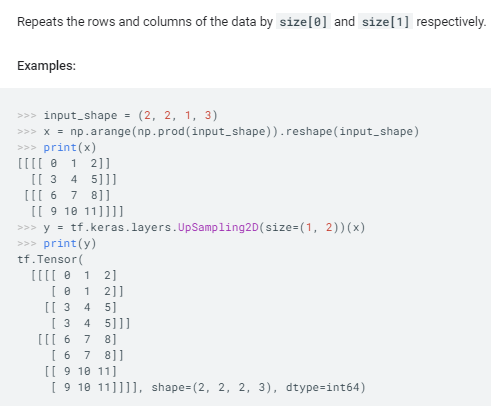


<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f6e1e2f2940> tf.Tensor(
[[-1.1128823   0.23753151 -0.12281758  0.12500125 -0.05361798 -1.0546347
   0.11372747 -1.1361449   0.01766143 -0.00525459 -1.823029    0.06605219
   0.18192685  0.81748337  0.41412267  0.36047995  0.47897837 -1.1632357
  -0.7034888   0.69914454  1.6332608   0.5577816   1.180305   -0.89838904
   0.09773212 -0.03123024 -0.348071   -0.66602635  0.7625065  -0.41112682
   0.9681403   0.58918303 -1.3752904   0.6757106   1.1540177   0.691627
  -2.2491105  -0.00885424 -0.4935387  -1.7184248  -1.1748384   0.63837934
   0.31486636  0.32372874  0.60924435  0.80593884  0.3903184  -0.97671616
   0.9976435   0.14458205 -0.6637773   0.16216923  0.5620929   0.6816055
   0.5351619   0.72081584  0.7143298   0.45726955  0.33261243  0.751869
  -0.5683461  -0.53213733  0.35620576 -1.1280864  -2.0632088  -0.86693734
  -0.88867956 -0.22525138 -1.460962    0.1860476   1.3125896  -0.13011773
   0.15880033 -1.1272799  -0

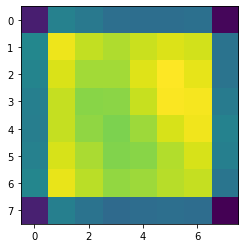

In [ ]:
def make_generator_model(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same", kernel_initializer='ones'))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Activation("relu"))


    return model

generator = make_generator_model(SEED_SIZE, IMAGE_CHANNELS)


print(generator, noise)
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])


**tf.keras.layers.Conv2DTranspose** (upsampling) layers to produce an image from a seed (random noise)

<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f6bfc213978> tf.Tensor(
[[-1.1128823   0.23753151 -0.12281758  0.12500125 -0.05361798 -1.0546347
   0.11372747 -1.1361449   0.01766143 -0.00525459 -1.823029    0.06605219
   0.18192685  0.81748337  0.41412267  0.36047995  0.47897837 -1.1632357
  -0.7034888   0.69914454  1.6332608   0.5577816   1.180305   -0.89838904
   0.09773212 -0.03123024 -0.348071   -0.66602635  0.7625065  -0.41112682
   0.9681403   0.58918303 -1.3752904   0.6757106   1.1540177   0.691627
  -2.2491105  -0.00885424 -0.4935387  -1.7184248  -1.1748384   0.63837934
   0.31486636  0.32372874  0.60924435  0.80593884  0.3903184  -0.97671616
   0.9976435   0.14458205 -0.6637773   0.16216923  0.5620929   0.6816055
   0.5351619   0.72081584  0.7143298   0.45726955  0.33261243  0.751869
  -0.5683461  -0.53213733  0.35620576 -1.1280864  -2.0632088  -0.86693734
  -0.88867956 -0.22525138 -1.460962    0.1860476   1.3125896  -0.13011773
   0.15880033 -1.1272799  -0

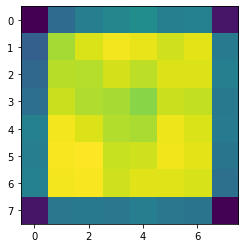

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose
def make_generator_model(seed_size, channels):
    model = Sequential()

    model.add(Dense(8*8*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((8,8,256)))

    model.add(Conv2DTranspose(256,kernel_size=3, padding='same', kernel_initializer='ones'))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    return model

generator = make_generator_model(SEED_SIZE, IMAGE_CHANNELS)


print(generator, noise)
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

The code below creates the generator and discriminator. Both will be trained with the Adam optimizer.

**Activation Functions**

1.   Rectified Linear Unit (ReLU):
![Image](https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

```
def relu_function(x): 
    if x<0: 
        return 0 
    else: 
        return x 
```
2.   Leaky ReLU: 
![Image](https://i.stack.imgur.com/LZk6i.png)

```
def leaky_relu_function(x): 
    if x<0: 
        return 0.01*x 
    else: 
        return x 
```
3.   Sigmoid :
![Image](https://miro.medium.com/max/1190/1*f9erByySVjTjohfFdNkJYQ.jpeg)


```
def sigmoid_function(x): 
    z = (1/(1 + np.exp(-x))) 
    return z 
```





### **Conv2D**
```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```
* filters: number of output filters in the convolution.
* kernel_size: dimensions of the kernel
* padding:	one of "valid" or "same"
  * “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.
  * preserve spatial dimensions of the volume such that the output volume size matches the input volume size, by setting the value to the “same”.
* strides: This parameter is an integer or tuple/list of 2 integers, specifying the “step” of the convolution along with the height and width of the input volume.


### **Dropout:** It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.



In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(64,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(64,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.05))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.05))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

As we progress through training images will be produced to show the progress.  These images will contain a number of rendered faces that show how good the generator has become.  These faces will be 

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)


  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f6374436710> tf.Tensor(
[[ 1.4270594  -1.6955909  -2.4228885  -1.2638369  -0.09901168  0.16377595
  -1.373425    0.11892121  0.4540608  -0.82215804 -0.56416315  0.7273046
  -0.3242842   1.8214754  -2.5126944  -0.04526004 -0.32379732 -0.29573932
   0.4780776   1.1832304  -0.43812558  0.18895163  0.7898213  -0.340255
   0.8023208  -0.53842115 -0.19204745 -0.90818477  0.83037245 -0.8456546
  -0.37660226  0.71230996  1.1621819   0.8065325  -0.33814678  1.3471825
  -0.49210906  0.893824   -1.0540866  -0.17648868 -0.39092696  1.0490979
   0.9189084  -0.37300703  0.30797982 -0.45530477  1.5760388   0.5706095
  -0.9082256   1.6990857   1.4616339   2.4746203  -1.486798   -0.969382
   1.494751   -1.7136011  -0.7471828   2.1964824   1.9394892   0.89861107
   0.04724604  0.4600378   0.05881418  0.20577359  1.6049688   1.2470862
   1.3259027  -0.51724416  0.23055038 -0.58131945  0.06882811 -0.9315587
   0.26046368 -0.98008883 -1.272

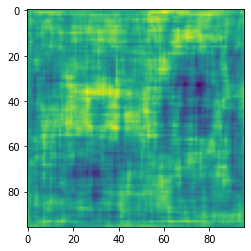

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
print(generator, noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])


In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49942014]], shape=(1, 1), dtype=float32)


Loss functions developed to allow the generator and discriminator to be trained in an adversarial way. 
When the discriminator's gradients are applied to decrease the discriminator's loss it is important that only the discriminator's weights are update.  It is not fair, nor will it produce good results, to adversarially damage the weights of the generator to help the discriminator.  A simple backpropagation would do this.  It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

Figure 7.TDIS shows how the discriminator is trained.

**Figure 7.TDIS: Training the Discriminator**
![Training the Discriminator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_2.png "Training the Discriminator")

Here a training set is generated with an equal number of real and fake images.  The real images are randomly sampled (chosen) from the training data.  An equal number of random images are generated from random seeds.  For the discriminator training set, the $x$ contains the input images and the $y$ contains a value of 1 for real images and 0 for generated ones.

Likewise, the Figure 7.TGEN shows how the generator is trained.

**Figure 7.TGEN: Training the Generator**
![Training the Generator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_3.png "Training the Generator")

For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.

* **BinaryCrossentropy** Computes the cross-entropy loss between true labels and predicted labels.
* **tf.ones_like:** Given a single tensor (tensor), this operation returns a tensor of the same type and shape as tensor with all elements set to 1.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

The following function is where most of the training takes place for both the discriminator and the generator.  This function was based on the GAN provided by the [TensorFlow Keras exmples](https://www.tensorflow.org/tutorials/generative/dcgan) documentation.  The first thing you should notice about this function is that it is annotated with the **tf.function** annotation.  This causes the function to be precompiled and improves performance.

This function trans differently than the code we previously saw for training.  This code makes use of **GradientTape** to allow the discriminator and generator to be trained together, yet separately.  



In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:

def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6726499795913696,disc loss=1.07138991355896, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.6765369176864624,disc loss=1.063398003578186, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=0.6698822379112244,disc loss=1.0868077278137207, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=0.6700941920280457,disc loss=1.0911881923675537, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=0.6789644956588745,disc loss=1.0550397634506226, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=0.6844049096107483,disc loss=1.0340805053710938, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=0.6882610321044922,disc loss=1.0213425159454346, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=0.6898452043533325,disc loss=1.0169181823730469, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=0.6899667978286743,disc loss=1.0155596733093262, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=0.6906439661979675,disc loss=1.0139834880828857, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=0.6911895275115967,disc loss=1.01

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

#Output

**GAN Neural Network Training 4 Epoch**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-4.png "GAN Images")

**GAN Neural Network Training 10 Epoch**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-10.png "GAN Images")


**GAN Neural Network Training 13 Epoch**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-13.png "GAN Images")


**GAN Neural Network Training 15 Epoch**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-15.png "GAN Images")


**GAN Neural Network Training 37 Epoch**
![GAN](https://raw.githubusercontent.com/shakshisinghai/Generative-Adversarial-Network-GAN/main/Images/train-37.png "GAN Images")